# Modèles de « décharge moyenne » de réseaux de neurones




## Introduction

Nous allons utiliser des modèles mathématiques pour décrire la dynamique d'une seule ou de plusieurs populations de neurones pour comprendre les différentes régimes dynamiques que l'on peut observer par ex. dans le cortex.

Pour faire simple (et ne pas échouer devant un trop de compléxité), nous étudierons des « modèles de décharge moyenne » ("rate models"), qui décrivent l'évolution du taux de décharge moyen d'une population de neurones.

Nous allons combiner calcul analytique (au tableau) et calcul numérique (dans ce « notebook » avec python).  
  

#### Contact 


N'hesitez pas à m'écrire si vous avez des questions :  

Jonas Ranft, jonas.ranft@ens.fr   
Neuronal algorithms team  
IBENS, Ecole Normale Supérieure


## Théorie 1: Modèle pour une seule population : equation dynamique et stabilité
## Numerics 1: Plotting basics, f-I curve, numerical solution to diff. eq.

Import python packages:

In [1]:
%matplotlib inline
from numpy import *    # import all commands from the numpy package
import matplotlib.pyplot as plt   # import plot package

Test plotting:

Text(0,0.5,'$y = x^2$')

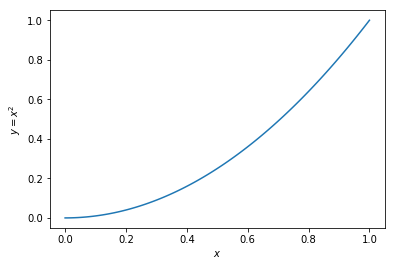

In [2]:
x = linspace(0,1,100)
y = x**2
fig, ax = plt.subplots(1,1)
ax.plot(x,y)
ax.set_xlabel('$x$')
ax.set_ylabel('$y = x^2$')

Now, define f-I transfer function to express firing rate of population as function of input current:

In [3]:
# set standard parameters (explore below!)
fmax = 500.0     # Hz
Ioffset = 10.0   # mV
steepness = 0.1  # 1/mV

# f-I curve
def fI(I, fmax=fmax, Ioffset=Ioffset, steepness=steepness):
    """fI(I, kwargs**) returns the population firing rate (in Hz) 
    for a given input current I (in mV)."""
    return fmax*0.5*(1.0+tanh((I-Ioffset)*steepness))

# we need the inverse function as well:
def fI_inv(r, fmax=fmax, Ioffset=Ioffset, steepness=steepness):
    y = 2.0*r/fmax - 1.0
    return arctanh(y)/steepness + Ioffset

# and also its derivative with respect to current
def fI_deriv(I, fmax=fmax, Ioffset=Ioffset, steepness=steepness):
    y = (I-Ioffset)*steepness
    return fmax*0.5*(1.0-tanh(y)**2)*steepness

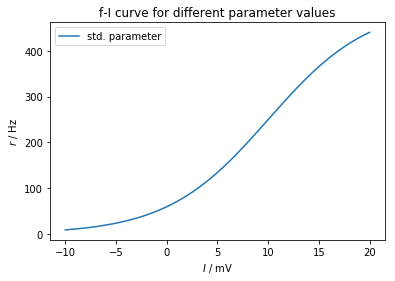

In [4]:
# plot f-I curve: firing rate as fct. of input current
Ix = linspace(-10, 20, 200) # array with current values

fig, ax = plt.subplots(1,1)
ax.set_title("f-I curve for different parameter values")
ax.plot(Ix, fI(Ix), label='std. parameter')
#ax.plot(Ix, fI(Ix, Ioffset=0.0), label='Ioffset=0.0')
#ax.plot(Ix, fI(Ix, steepness=1.0), label='steepness=2.0')
#ax.plot(Ix, fI(Ix, fmax=350.0), label='fmax=350.0')
ax.set_xlabel('$I$ / mV')
ax.set_ylabel('$r$ / Hz')
ax.legend()

# TODO: uncomment plots of f-I curves with modified parameters

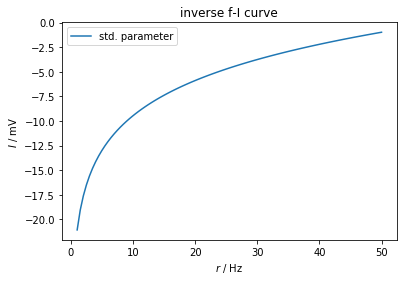

In [5]:
# plot inverse of transfer function
rx = linspace(1, 50, 100) # array with rate values

fig, ax = plt.subplots(1,1)
ax.set_title("inverse f-I curve")
ax.plot(rx, fI_inv(rx), label='std. parameter')
ax.set_ylabel('$I$ / mV')
ax.set_xlabel('$r$ / Hz')
ax.legend()

Let us now consider a network the firing rate dynamics of which is described by
$$\frac{\rm d}{{\rm d}t} r(t) = \frac{1}{\tau} \left[ f(I(t)) - r(t)\right],$$ where the input $I(t) = I_{\rm ext} + w*r(t)$ is composed of a (constant) external drive and recurrent connections with strength $w$.

The network can be in a stationary state $r^*$ for which $$r^* = f(I_{\rm ext} + w r^*).$$ We can calculate the total input current for a given firing rate, and the corresponding external current as a function of the connection weight for this firing rate to be stationary. We can furthermore calculate whether this state is stable or unstable with respect to small perturbations of the firing rate.

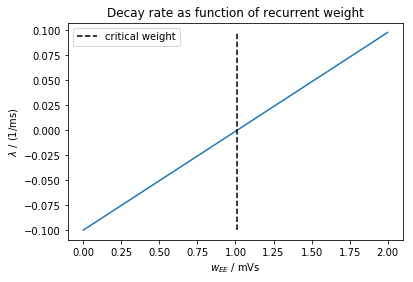

In [6]:
# chosen steady state firing rate
Re = 5.0 # Hz
Itot = fI_inv(Re)

# relaxation time constant of rate dynamics 
tau = 10.0 # ms

# 'critical' weight for which dynamics becomes unstable:
wcrit = 1.0/fI_deriv(Itot)

# plot decay rate vs. weight with critical weight
wx = linspace(0,2,100) # mV/Hz
lam = (wx*fI_deriv(Itot)- 1.0)/tau # 1/ms

fig, ax = plt.subplots(1,1)
ax.set_title('Decay rate as function of recurrent weight')
ax.plot(wx, lam)
ax.plot([wcrit, wcrit], lam[[0,-1]], '--k', label='critical weight')
ax.set_xlabel('$w_{EE}$ / mVs')
ax.set_ylabel('$\lambda$ / (1/ms)')
ax.legend()


Now, solve dynamic equation in time:

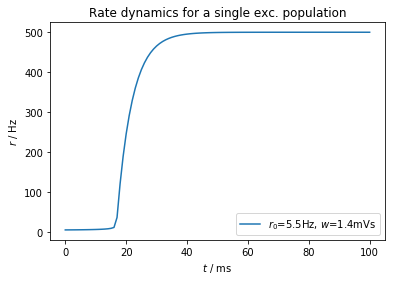

In [7]:
# fix parameter values
Re = 5.0 # Hz
w = 1.4  # mV/Hz (or mVs)
Iext = fI_inv(Re) - w*Re   # mV
tau = 5.0

# dynamics is defined by derivative of the rate
def drdt(r, t):
    It = Iext + w*r
    r0 = fI(It)
    return (r0 - r)/tau

# import numerical solver of differential equations
from scipy.integrate import odeint

# initial value of rate
r0 = 1.1*Re

timepoints = linspace(0, 100, 101) # time in ms
r_of_t = odeint(drdt, r0, timepoints)

fig, ax = plt.subplots(1,1)
ax.set_title('Rate dynamics for a single exc. population')
ax.plot(timepoints, r_of_t, label='$r_0$=%gHz, $w$=%gmVs'%(r0, w))
ax.set_xlabel('$t$ / ms')
ax.set_ylabel('$r$ / Hz')
ax.legend()

# TODO: plot evolution starting from 2nd initial value, 
#       for a different value of w, ...


## Théorie 2: Modèle à plusieurs populations : couplage excitateur-inhibiteur ; stabilité linéaire d'un système dynamique à 2 variables  

## Numerics 2: Matrix eigenvalues, solution of system of differential equations

As seen on the blackboard, we now consider the dynamics of two coupled populations, each described by a dynamic equation for the firing rate as a function of a current input:
$$\frac{\rm d}{{\rm d}t} r_E(t) = \frac{1}{\tau} \left[ f(I_{{\rm ext}, E} + w_{EE} r_E(t) + w_{EI}r_I(t)) - r_E(t)\right],$$
$$\frac{\rm d}{{\rm d}t} r_I(t) = \frac{1}{\tau} \left[ f(I_{{\rm ext}, I} + w_{IE} r_E(t) + w_{II}r_I(t)) - r_I(t)\right].$$
Like in the single population case, we can linearize the dynamics around a fixed point, which is now characterized by two firing rates, and depends on both external inputs and all four connections strengths. The linear dynamics is then characterized by a matrix, the eigenvalues of which tell us whether the fixed point is stable or unstable, oscillatory or not.

Let's do the eigenvalue decomposition numerically:

In [8]:
# import necessary functions
from numpy.linalg import eigvals

In [9]:
# fixed point
Re = 5.0   # Hz
Ri = 10.0  # Hz 

# total input currents at fixed point given by inverse
ItotE = fI_inv(Re) # mV
ItotI = fI_inv(Ri) 

# connection weights
wee = 2.5  # mV/Hz
wei = 1.0
wie = 2.0
wii = 1.0

# --> weight matrix
W = array([[wee, -wei],
           [wie, -wii]])

tau = 10.0 # ms

# linearized coupling matrix
L = array([[wee*fI_deriv(ItotE) - 1.0,       -wei*fI_deriv(ItotE)],
           [wie*fI_deriv(ItotI)      , -1.0 - wii*fI_deriv(ItotI)]])/tau


# array notation is shorter:
R = array([Re, Ri])
Itot = fI_inv(R)
dfI = fI_deriv(Itot)
L2 = (W*dfI[:,None]-eye(2))/tau

print('Eigenvalues of linearized dynamics: ', eigvals(L))

Eigenvalues of linearized dynamics:  [ 0.02755895 -0.17605895]


Calculate some characteristics of phase diagram: 'critical' lines, frequencies from imaginary part (f = omega/2 pi), ...

In [10]:
# start with analysis of eigenvalues for chosen parameters
ev = eigvals(L)

# check real part for stability
lam12 = real(ev)
print('Real part of eigenvalues: ', real(ev))


if any(lam12>0):
    print('--> fixed point expected to be unstable!')
else:
    print('--> fixed point expected to be stable!')

# check imaginary part for oscillation
omega = abs(imag(ev[0]))  # 1/ms
print('Imaginary part of eigenvalues (+/-): ', omega) 

# if non-zero, only sign differs between both
if omega>0:
    print('--> corresponds to oscillation frequency of %g Hz'%(1e3*omega/(2*pi)))
else:
    print('--> no oscillation expected...')

Real part of eigenvalues:  [ 0.02755895 -0.17605895]
--> fixed point expected to be unstable!
Imaginary part of eigenvalues (+/-):  0.0
--> no oscillation expected...


Solve the full (nonlinear) dynamics of the system:

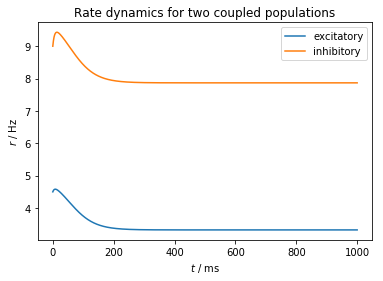

In [11]:
# external currents at fixed point follow from rates & weights
Iext = Itot - W.dot(R)

# dynamics is again defined by derivative of rates 
def drdt(r, t):
    #  r = [re, ri]
    r0 = fI(Iext+W.dot(r))
    return (r0-r)/tau

# import numerical solver of differential equations
from scipy.integrate import odeint

# initial values of firing rates
r0 = 0.9*R

timepoints = linspace(0, 1000, 5001) # time in ms
r_of_t = odeint(drdt, r0, timepoints)

fig, ax = plt.subplots(1,1)
ax.set_title('Rate dynamics for two coupled populations')
ax.plot(timepoints, r_of_t[:,0], label='excitatory')
ax.plot(timepoints, r_of_t[:,1], label='inhibitory')
ax.set_xlabel('$t$ / ms')
ax.set_ylabel('$r$ / Hz')
ax.legend()



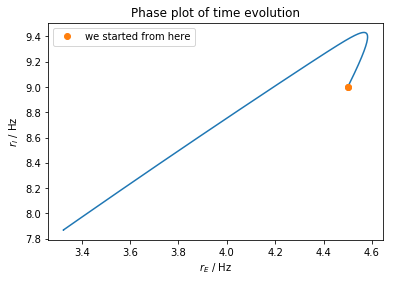

In [12]:
# plot the trajectory in the phase space (r_E, r_I)
# --> plot r_I(t) against r_E(t)

fig, ax = plt.subplots(1,1)
ax.set_title('Phase plot of time evolution')
ax.plot(r_of_t[:,0], r_of_t[:,1])
ax.plot([r0[0]]*2, [r0[1]]*2, 'o', label='we started from here')
ax.set_xlabel('$r_E$ / Hz')
ax.set_ylabel('$r_I$ / Hz')
ax.legend()

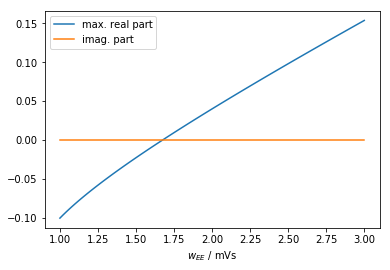

In [13]:
def linear_dynamics_eigenvalues(wee, wei, wie, wii):
    W = array([[wee, -wei], [wie, -wii]])
    L = (W*fI_deriv(fI_inv(R))[:,None] - eye(2))/tau
    ev = eigvals(L)
    return max(real(ev)), abs(imag(ev[0]))

# look at range of weight values
wx = linspace(1,3,100)
wee_line = array([linear_dynamics_eigenvalues(w, 1.0, 1.0, 1.0) for w in wx])

fig, ax = plt.subplots(1,1)
ax.plot(wx,wee_line[:,0], label='max. real part')
ax.plot(wx,wee_line[:,1], label='imag. part')
ax.set_xlabel('$w_{EE}$ / mVs')
ax.legend()

If we want to have an idea of the dynamical regimes in the multi-dimensional parameter space of weights:

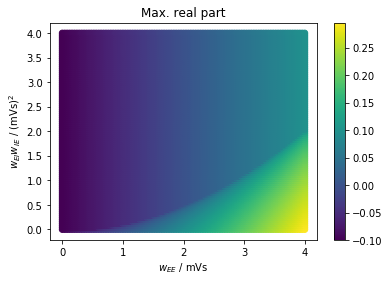

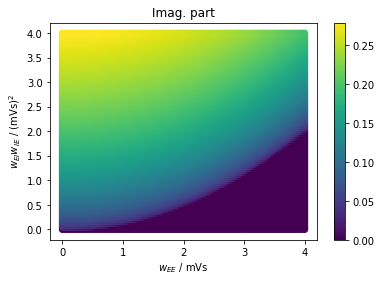

In [14]:

# define grid of wee, wei*wie values for which we evaluate the 
# eigenvalues of the linear dynamics
# NOTE: we need to fix wii to look at plane (wee vs. (wei.wie))
wii = 0.0
we = linspace(0,4,101)
wprod = linspace(0,4,101)

w_space = zeros((len(wprod), len(we), 2))

# loop over all weight values that we want to evaluate
for i1, w1 in enumerate(we):
    for i2, w2 in enumerate(wprod):
        w_space[i2,i1] = linear_dynamics_eigenvalues(w1, w2, 1.0, wii)

X,Y = meshgrid(we, wprod)

fig, ax1 = plt.subplots(1,1)
ax1.set_title('Max. real part')
sc1 = ax1.scatter(x=X, y=Y, c=w_space[:,:,0])
ax1.set_xlabel('$w_{EE}$ / mVs')
ax1.set_ylabel('$w_{EI} w_{IE}$ / (mVs)$^2$')
plt.colorbar(sc1)

fig, ax2 = plt.subplots(1,1)
ax2.set_title('Imag. part')
sc2 = ax2.scatter(x=X, y=Y, c=w_space[:,:,1])
ax2.set_xlabel('$w_{EE}$ / mVs')
ax2.set_ylabel('$w_{EI} w_{IE}$ / (mVs)$^2$')
plt.colorbar(sc2)

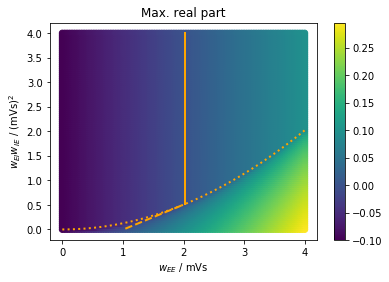

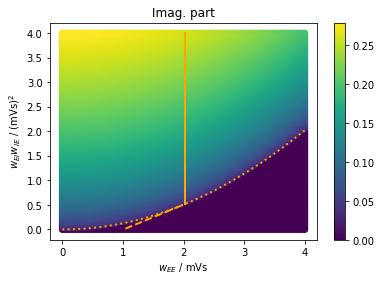

In [15]:
# now, plot same graphs but with analytically predicted,
# calculated phase boundaries superposed

fig, ax1 = plt.subplots(1,1)
ax1.set_title('Max. real part')
sc1 = ax1.scatter(x=X, y=Y, c=w_space[:,:,0])
ax1.set_xlabel('$w_{EE}$ / mVs')
ax1.set_ylabel('$w_{EI} w_{IE}$ / (mVs)$^2$')
plt.colorbar(sc1)

fig, ax2 = plt.subplots(1,1)
ax2.set_title('Imag. part')
sc2 = ax2.scatter(x=X, y=Y, c=w_space[:,:,1])
ax2.set_xlabel('$w_{EE}$ / mVs')
ax2.set_ylabel('$w_{EI} w_{IE}$ / (mVs)$^2$')
plt.colorbar(sc2)


# condition 1: instability for large values of wee
crit_wee = (2.0 + wii*dfI[1])/dfI[0]
wprod_at_crit_wee = (crit_wee*dfI[0] + wii*dfI[1])**2/(4*dfI.prod())
for ax in [ax1, ax2]:
    ax.plot([crit_wee]*2, [wprod_at_crit_wee, wprod[-1]], color='orange', lw=2)

# condition 2: imaginary eigenvalues -> oscillatory dynamics (stable or unstable)
crit_wprod_imag = (we*dfI[0] + wii*dfI[1])**2/(4*dfI.prod())
for ax in [ax1, ax2]:
    ax.plot(we, crit_wprod_imag, color='orange', lw=2, linestyle=':')

# condition 3: instability below the critical value of wee
crit_wprod_stability = (we*dfI[0] - 1)/dfI.prod()
# NOTE: only applicable for wee < crit_wee and wei*wie > 0
icrit = next(i for i,w in enumerate(we) if w>crit_wee)
ipos = next(i for i,w in enumerate(crit_wprod_stability) if w>0)
for ax in [ax1, ax2]:
    ax.plot(we[ipos:icrit], crit_wprod_stability[ipos:icrit], color='orange', lw=2, linestyle='--')

# TODO: go back to look at dynamics for specific points in parameter space! 